In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from string import punctuation
from sklearn import svm
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain

from sklearn.metrics import recall_score, f1_score

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.shape

(568454, 10)

In [4]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [5]:
pos = df[df['Score']>3]
neg = df[df['Score']<3]
print pos.shape, neg.shape

(443777, 10) (82037, 10)


In [6]:
pos = pos.head(neg.shape[0])
print pos.shape, neg.shape
df = pd.concat([pos,neg])

(82037, 10) (82037, 10)


In [7]:
df = shuffle(df)
df.head()

Id   ProductId          UserId            ProfileName  \
44848    44849  B000FPM5DA   AK0CENM3LUM28            Ana Mardoll   
536288  536289  B0051ZCNIQ   AMQ1MEG334SAP                 Bigmac   
113083  113084  B000LKXBL4   AKGQ6RM68SQY1  Catherine Diane "CDI"   
49635    49636  B000RE93ZC  A36799MFLN1DWV              kriscraft   
377371  377372  B004M62COU  A2OBA2ZLFJX23X                 Rabbit   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
44848                      0                       0      4  1222819200   
536288                     0                       3      1  1332892800   
113083                     2                       3      1  1336521600   
49635                      0                       0      5  1344643200   
377371                     0                       5      2  1310947200   

                                                 Summary  \
44848                           Good Treat in Moderation   
536288  My Dog Wouldn't Touch this with a Ten Foot Pole!   
113083       ONLY awful because SOMETIMES they are awful   
49635                                        easy coffee   
377371                   Received in plain cardboard box   

                                                     Text  
44848   Dingo Munchy Stick / B000FPM5DA<br /><br />Whe...  
536288  My dog seems to be allergic to poultry so we t...  
113083  and THAT is  the problem. I order these by the...  
49635   I like just dropping the filter pack (or two o...  
377371  This was so disappointing. I was happy to get ...

## Preprocessing

Remove all nutral scores and seperate the remaning into positive = 1 and negative = 0
Preprocessing ususally involves:
1. Removing additional white spaces
2. Replacing emoji's with a word representation for example :) ==> smile
3. Removing links from the corpus
4. Removing punction
5. Removing anh HTML tags
6. Remove duplicate reviews

Here is a good blog on how to [process text](http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/)

For this exercise we will only tokenize reviews, that is change `"This is a review"` to `['this', 'is', 'a', 'review']`

Once the text is 'clean' we will use sklearn:
1. CountVectorizer - Convert a collection of text documents to a matrix of token counts
2. TfidfVectorizer - Convert a collection of raw documents to a matrix of TF-IDF features


In [8]:
df = df[df['Score'] !=3]
X = df['Text']
y_map = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_map)

In [9]:
X.head()

44848     Dingo Munchy Stick / B000FPM5DA<br /><br />Whe...
536288    My dog seems to be allergic to poultry so we t...
113083    and THAT is  the problem. I order these by the...
49635     I like just dropping the filter pack (or two o...
377371    This was so disappointing. I was happy to get ...
Name: Text, dtype: object

In [10]:
y.head()

44848     1
536288    0
113083    0
49635     1
377371    0
Name: Score, dtype: int64

## Classification

Once the text is processed the next step is to do the actual classificaiton. For this exercise we will be using a Logistic Regression Classifier. However there are many other popular classifiers that may perform better:
1. Support Vector Machine and its variants
2. Naive Bayes and its variants
3. Random Forests and its variants 

We created a function that takes in the training set `X` , test set `y`, the model being used `model` and the classification algorithm `clf_model` as well as a variable that will show the top coefficients if true  `coef_show`

In [11]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test,y_pred)
#     acc = clf.score(X_test, y_test)
    print ('Model Recall: {}'.format(recall))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))

## Classification Experiments

1. Logistic regression model on word count
3. Logistic regression model on TFIDF
2. Logistic regression model on TFIDF + ngram

NGram Defn:
N-grams of texts are extensively used in text mining and natural language processing tasks. They are basically a set of co-occuring words within a given window and when computing the n-grams you typically move one word forward (although you can move X words forward in more advanced scenarios). Taken from [here](http://text-analytics101.rxnlp.com/2014/11/what-are-n-grams.html)

In [12]:
text_fit(X, y, c, LogisticRegression())

# features: 68923
# train records: 123055
# test records: 41019
Model Recall: 0.905561486946

-Top 20 positive-
Coefficient           Word
   2.827427     pleasantly
   2.659867       perruche
   2.297730         hooked
   2.247194        welcome
   2.207646        jimmies
   2.181008       receives
   2.176654       drawback
   2.152787         resist
   2.133620           vast
   2.083493          fumes
   2.068144            met
   2.054893        worries
   2.047186      delighted
   2.045618    substitutes
   2.021876       downside
   1.998783  emeraldforest
   1.987404        iprozon
   1.983831      freshener
   1.975325      satisfies
   1.949808      addicting

-Top 20 negative-
Coefficient            Word
  -2.155965           blech
  -2.158820          stitch
  -2.160588       disgusted
  -2.186924          ripoff
  -2.190037           veggi
  -2.208313         boredom
  -2.259430           schar
  -2.334697          endure
  -2.354722          freind
  -2.360944           

In [13]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 68923
# train records: 123055
# test records: 41019
Model Recall: 0.896049694264

-Top 20 positive-
Coefficient        Word
  11.361236       great
  10.177400   delicious
   9.523166        best
   9.313465     perfect
   7.950639   excellent
   7.913446       loves
   7.234493        love
   7.118159      highly
   6.872065   wonderful
   6.605531     amazing
   6.455946     awesome
   6.439855        good
   6.327632    favorite
   6.126951        nice
   5.876564       yummy
   5.822980     pleased
   5.728463        glad
   5.694190      hooked
   5.520417  pleasantly
   5.477912        easy

-Top 20 negative-
Coefficient            Word
  -5.299588           sorry
  -5.332289           money
  -5.455697           hopes
  -5.628636           waste
  -5.883909          hoping
  -5.970795           stale
  -5.982591         thought
  -6.025461      disgusting
  -6.179774           threw
  -6.200927          return
  -6.381742           bland
  -6.913658  disappointment
 

In [14]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 1932701
# train records: 123055
# test records: 41019
Model Recall: 0.910268853732

-Top 20 positive-
Coefficient       Word
  17.336896      great
  14.008323       best
  13.969089  delicious
  12.345396    perfect
  11.200692      loves
  11.127608       love
  10.222272  excellent
   9.462664       good
   9.238204  wonderful
   9.201151   favorite
   9.152207       nice
   7.899394       easy
   7.829069    amazing
   7.510370    awesome
   7.474082      happy
   6.977178     highly
   6.900244      yummy
   6.889039    pleased
   6.865877      tasty
   6.682869       glad

-Top 20 negative-
Coefficient            Word
  -6.441333      disgusting
  -6.633843           waste
  -6.707379           maybe
  -6.831603           threw
  -6.841856          hoping
  -7.116553  disappointment
  -7.352165             bad
  -7.475864           bland
  -7.545568          return
  -7.733966           money
  -7.858457           stale
  -8.660033            weak
  -8.801232         

## Topic Modelling

Non Negative Matrix Factorization (NMF), Latent Dirichlet Allocation (LDA) and Single Value Decomposition (SVD)algorithms will be used to find topics in a document collection. The output of the derived topics involved assigning a numeric label to the topic and printing out the top words in a topic. 

The algorithms are not able to automatically determine the number of topics and this value must be set when running the algorithm. Comprehensive documentation on available parameters is available for both [NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html), [LDA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and [SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). 




In [25]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print "Topic %d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print 
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print documents[doc_index]
            print 

In [26]:
documents = list(X)[0:10000]
print len(documents)

10000


In [27]:

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [28]:
no_topics = 5

In [29]:
# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

In [60]:
# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

In [31]:
#SVD
lsi_model = TruncatedSVD(n_components=no_topics, n_iter=7, random_state=42).fit(tf)
lsi_W = lsi_model.transform(tf)
lsi_H = lsi_model.components_


In [32]:
no_top_words = 10
no_top_documents = 4
print "NMF Topics \n\n"
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)


NMF Topics 


Topic 0:
like taste product good flavor just great love really chocolate

Tried these for a Gold Box deal and LOVE them!  They do have a bit of a crumbly texture, although they seem to hold up well in the package.  And if you don't like coconut, you might not like these.  But to me, they taste like yummy cookies!  I don't eat gluten free or dairy free so I can compare these to other bars that can't make those claims and tell you that these are good.  Soft and sweet (and a natural tasting sweet, not artificial), just the right amount of chocolate chips if you're eating these as a snack to not feel like a treat.  Great ingredients.  I will definitely buy these again!

It took me a long time to try these larabars out and I don't know what really prompted me to try one finally but I am so glad I did.  From the flavors that I have tried some just blew me away while some really left me feeling unsatisfied in the flavor department.  I will rate the ones out of 5 stars that I hav

In [33]:
print "\n\nLDA Topics \n\n"
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)




LDA Topics 


Topic 0:
br like taste just coffee good flavor tea great product

Shake N Bake in the original pork flavor has been a guilty pleasure of mine since I was a little girl. When I was a kid, it was often what I would request for my birthday dinner and I still crave Shake N Bake pork chops every now and then.<br /><br />When I selected the Shake N Bake Pork Pouch, I really wasn't sure what it was. I thought maybe it was a pouch that you put the pork chop in and cooked it in the pouch. I was completely wrong.<br /><br />The pouch is just a packet of the Shake N Bake mix. That's it. There is no little plastic bag to shake the chops in, so you have to provide your own bag. Not only that, but the pouch is only 2.25-ounces, as opposed to the 3-ounce packets you get in the standard Shake N Bake box, so it coats fewer pork chops. To be fair, it does state on the back of the pouch that this packet makes 4-6 pork chops instead of the 6-8 chops the 3-ounce packet makes.<br /><br />For

In [34]:
print "\n\nLSI Topics \n\n"
display_topics(lsi_H, lsi_W, tf_feature_names, documents, no_top_words, no_top_documents)



LSI Topics 


Topic 0:
br like food just product taste good flavor coffee tea

.....SUBTITLE:  READ THE E N T I R E....DESCRIPTION CAREFULLY OF ANYTHING<br />  YOU BUY!<br /><br />JUICY JUICE has a reputation for being 100% juice.  Always!  No additives, preservatives....and even no extra sweeteners!  It is<br />also often regarded as a children's beverage -- and to me, that<br />means the manufacturers have taken EXTRA care that the product is<br />as good as can be.  After all, no manufacturer wants to be accused<br />of giving health problems, (now or in the future), or even out-<br />right poisoning, children!  To me, a product specifically made for<br />children, (and/or usually associated with children's eating or<br />drinking it), is often, (but not always), an inexpensive way to get<br />gourmet -- or almost gourmet -- quality food at a good price.<br /><br />I've had Juicey Juice before...and enjoyed it immensely.  But -- the<br />Juicy Juice I have heretofore imbibed was t

## Word Clouds


In [37]:
from wordcloud import WordCloud, STOPWORDS

In [50]:
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 

In [57]:
def print_cloud(data):
    wordcloud = WordCloud(
              background_color='white',
              max_words=200,
              max_font_size=40, 
              random_state=42
             ).generate(str(data))
df.shape

(164074, 10)

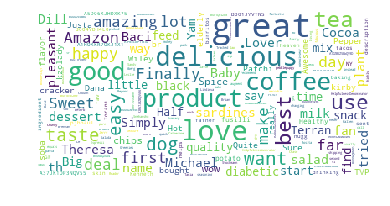

In [59]:
print_cloud(df['Score'])
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)